# **Interactive demo for out-of-core training on nnabla**

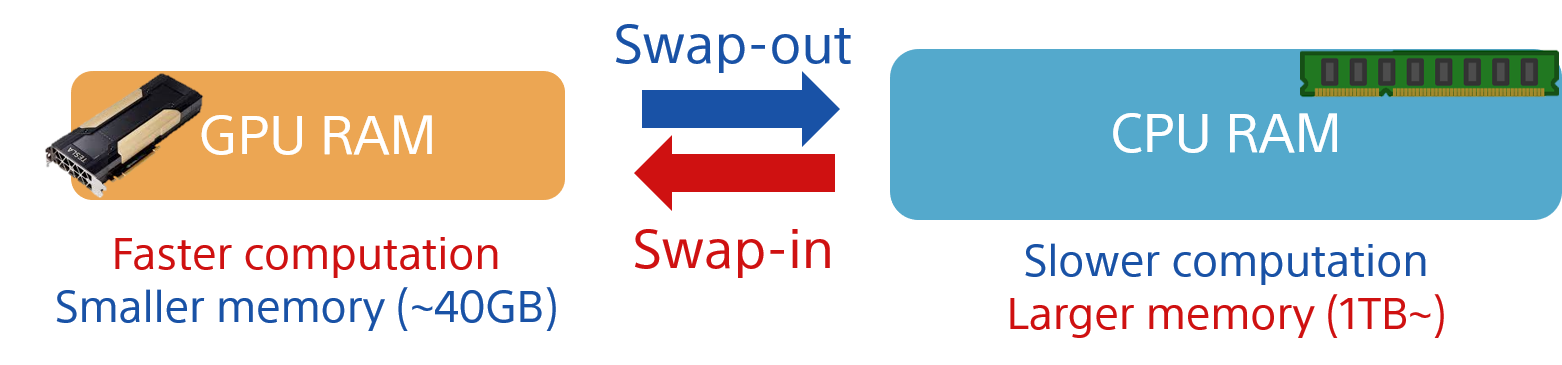

Welcome to nnabla's Out-of-Core (OoC) training demo. In this demo, you can interactively learn how to use OoC feature on nnabla. 

OoC is a general technique designed to process data that are too large to fit into a main memory at once. In nnabla, we support CPU-GPU memory swapping to enable training larger model than allotted GPU memory. 

This OoC feature would help you to ① improve the accuracy of your baseline model beyond GPU memory budget and ② train memory-intensive state-of-the-art model which comsumes more memory than you have.

**Note that the OoC feature is usefull only when CPU memory size is larger than GPU.** 

In paticular, if your environment has much more CPU memory than GPU memory (recent CPU RAM is in general larger than GPU RAM), you can make the best of our OoC feature!


## Preparation

First, let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click Connect on the top right-hand side of the screen before you start.

In [ ]:
# install nnabla
!pip install nnabla-ext-cuda101

# clone nnabla-examples
!git clone https://github.com/sony/nnabla-examples.git

%cd /content/nnabla-examples/mnist-collection

Below script imports all modules necessary for this demo. Note that OoC can be used under nnabla >= 1.16. If the installed version of nnabla is less than 1.16, below script will raise ValueError. In that case, please update your nnabla package to the proper version.

In [ ]:
import sys, os

os.environ["NNABLA_CUDNN_ALGORITHM_BY_HEURISTIC"] = '1'

from packaging import version
import numpy as np
from tqdm import trange

import nnabla as nn

if version.parse('.'.join(nn.__version__.split('.')[:3])) < version.parse("1.16.0"):
  raise ValueError("This OoC interactive demo can be run only with nnable >= 1.16")

import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
import nnabla.logger as logger
from nnabla.ext_utils import import_extension_module

sys.path.append("/content/nnabla-examples/utils/")
from neu.lms import lms_scheduler

# setup to use GPU
from nnabla.ext_utils import get_extension_context
ctx = get_extension_context("cudnn", device_id='0', type_config="float")
nn.set_default_context(ctx)

from nnabla_ext.cuda.init import get_device_memory_size
from nnabla import set_function_post_hook, unset_function_post_hook

init_gpu_usage = 0
def virtual_gpu_mem_limit(f):
  free, all = get_device_memory_size()
  used = all - free - init_gpu_usage

  if (used > 4 << 30):
    raise MemoryError("Out of memory. GPU memory usage exceeds 4GB.")

unset_function_post_hook("virtual_gpu_mem_limit")
set_function_post_hook("virtual_gpu_mem_limit", virtual_gpu_mem_limit)

# helper function to initialize nnabla env
def init_nnabla():
  # clear all parameters
  nn.clear_parameters()

  # clear all cache
  ext = import_extension_module("cudnn")
  ext.clear_memory_cache()

## MNIST classification demo

In this demo, you can try nnabla's Out-of-Core (OoC) API by training MNIST classification. Let's try our OoC feature with a simple MNIST classification task. 

Note that, throughout this demo, we assume that we only have small GPU memory budget to clearly show how OoC can be effective to train larger model and improve the accuracy with limited GPU memory budget. To do that, we simulate an environment with has only 4GB GPU memory. 

In [ ]:
batch_size = 256
max_iter = 5000
val_step = 100

# setup data iterator for mnist classification
from mnist_data import data_iterator_mnist
data = data_iterator_mnist(batch_size, True)
val_data = data_iterator_mnist(batch_size, False)
val_iter = val_data.size // batch_size

# define inputs vars
image = nn.Variable([batch_size, 1, 28, 28])
label = nn.Variable([batch_size, 1])

def SimpleCnn(images, c, test=False):
  with nn.parameter_scope("conv0"):
    h = PF.convolution(image, c, (3, 3), pad=(1, 1), with_bias=False)
    h = PF.batch_normalization(h, batch_stat=not test)
    h = F.relu(h)

  with nn.parameter_scope("conv1"):
    h = PF.convolution(h, c * 2, (3, 3), pad=(1, 1), with_bias=False)
    h = PF.batch_normalization(h, batch_stat=not test)
    h = F.relu(h)
    h = F.max_pooling(h, (2, 2))

  with nn.parameter_scope("conv2"):
    h = PF.convolution(h, c * 4, (3, 3), pad=(1, 1), with_bias=False)
    h = PF.batch_normalization(h, batch_stat=not test)
    h = F.relu(h)
    h = F.max_pooling(h, (2, 2))
  
  with nn.parameter_scope("conv3"):
    h = PF.convolution(h, c * 8, (3, 3), pad=(1, 1), with_bias=False)
    h = PF.batch_normalization(h, batch_stat=not test)
    h = F.relu(h)
  
  with nn.parameter_scope("affine"):
    h = F.max_pooling(h, h.shape[2:])
    h = PF.affine(h, 10)
  
  return h

def calc_error(pred, label):
    pred_label = np.argmax(pred, axis=1)
    return np.mean(pred_label != label.flat)

### Train small CNN which can be run on allotted GPU memory
First, let's train our baseline model on MNIST dataset. Here, we train a simple CNN network with 5 layers as a baseline. 

In [ ]:
try:
  free, all = get_device_memory_size()
  init_gpu_usage = all - free
  
  init_nnabla()

  y = SimpleCnn(image, c = 8, test=False)
  y.persistent = True
  loss = F.mean(F.softmax_cross_entropy(y, label))

  val_y = SimpleCnn(image, c = 8, test=True)

  solver = S.Adam(0.0001)
  solver.set_parameters(nn.get_parameters())

  res_orig = {"train": [], "val": []}

  for i in range(max_iter):
    image.d, label.d = data.next()
    
    loss.forward(clear_no_need_grad=True)

    solver.zero_grad()

    loss.backward(clear_buffer=True)
    
    solver.update()

    if (i + 1) % val_step == 0:
      terror = calc_error(y.d, label.d)
      res_orig["train"].append(terror)

      verror = 0.0
      val_data._data_source.reset()
      for j in range(val_iter):
          image.d, label.d = val_data.next()
          val_y.forward(clear_buffer=True)
          verror += calc_error(val_y.d, label.d)
      verror /= val_iter

      res_orig["val"].append(verror)

      logger.info("iter: {}, train loss: {}, train error: {} val error: {}".format(i+1, loss.d, terror, verror))

except Exception as e:
  print(e)
  pass

# tear down
del loss
del y
del solver
del val_y
init_nnabla()

2021-01-19 11:32:53,772 [nnabla][INFO]: iter: 100, train loss: 1.4732571840286255, train error: 0.3828125 val error: 0.4147636217948718
2021-01-19 11:32:54,786 [nnabla][INFO]: iter: 200, train loss: 0.8848931193351746, train error: 0.1953125 val error: 0.1828926282051282
2021-01-19 11:32:55,790 [nnabla][INFO]: iter: 300, train loss: 0.6538716554641724, train error: 0.11328125 val error: 0.10907451923076923
2021-01-19 11:32:56,794 [nnabla][INFO]: iter: 400, train loss: 0.4263516962528229, train error: 0.05859375 val error: 0.07872596153846154
2021-01-19 11:32:57,811 [nnabla][INFO]: iter: 500, train loss: 0.4003387987613678, train error: 0.08203125 val error: 0.06360176282051282
2021-01-19 11:32:58,820 [nnabla][INFO]: iter: 600, train loss: 0.3411523997783661, train error: 0.07421875 val error: 0.052884615384615384
2021-01-19 11:32:59,836 [nnabla][INFO]: iter: 700, train loss: 0.2601321041584015, train error: 0.0546875 val error: 0.046875
2021-01-19 11:33:00,853 [nnabla][INFO]: iter: 800

### Train larger CNN that consumes more than allotted GPU memory

After training is finished, you can see that our baseline model performs around 1% error for the validation dataset. 

While this result is pretty good, we can actually further improve this accuracy by simply making the model larger. In this baseline model, we use [8, 16, 32, 64] channel size for convolutions. Let's try to make them larger and see how the accuracy changes. In this example, we make them 16x larger ones.

Below script is for training 16x larger model than the baseline. Let's train the larger model.

In [ ]:
# this code will be failed with memory error!
try:
  free, all = get_device_memory_size()
  init_gpu_usage = all - free

  init_nnabla()

  # Use larger model
  y = SimpleCnn(image, c=128, test=False)

  y.persistent = True
  loss = F.mean(F.softmax_cross_entropy(y, label))

  solver = S.Adam(0.0001)
  solver.set_parameters(nn.get_parameters())

  # Training loop below will raise memory error!
  for i in range(max_iter):
    image.d, label.d = data.next() 

    loss.forward(clear_no_need_grad=True)

    solver.zero_grad()

    loss.backward(clear_buffer=True)
    
    solver.update()

    if (i + 1) % val_step == 0:
      error = calc_error(y.d, label.d)
      logger.info("iter: {}, loss: {}, error: {}".format(i+1, loss.d, error))
except Exception as e:
  print(e)
  pass

# tear down
del loss
del y
del solver
init_nnabla()

<built-in method backward of nnabla._variable.Variable object at 0x7f302c91a278> returned a result with an error set


Unfortunately, your training process would be stopped immediately and you cannot observe any results from this script.

This is because our larger model cannot be trained on 4GB GPU memory budget. In the actual deep learning development, you will get Out-of-Memory error on the same situation. 

In that situation, nnabla's OoC feature can help you. What's more, **all you have to do is adding a few lines to enable OoC training on nnable**. 

Like below script, we have only two steps to enable it.
First, initialize a scheduler:
```
scheduler = lms_scheduler(ctx, use_lms=True, gpu_memory_size=3.5e9, window_length=5e9)
```
then, specify which parts of computation you want to apply OoC training:
```
with scheduler:
      loss.forward(clear_no_need_grad=True)
      solver.zero_grad()
      loss.backward(clear_buffer=True)
      solver.update()
```
That's it!

Now you know how to use nnabla's OoC feature. Let's try below script to train our larger model. Note that, because of the bottleneck of memory transfer, the training process would last several minitues.

In [ ]:
try:
  free, all = get_device_memory_size()
  init_gpu_usage = all - free

  init_nnabla()

  # Use larger model
  y = SimpleCnn(image, c=128, test=False)

  val_y = SimpleCnn(image, c=128, test=True)

  y.persistent = True
  loss = F.mean(F.softmax_cross_entropy(y, label))

  solver = S.Adam(0.0001)
  solver.set_parameters(nn.get_parameters())

  res_ooc = {"train": [], "val": []}

  # Set up scheduler for OoC training
  scheduler = lms_scheduler(ctx, use_lms=True, gpu_memory_size=3.5e9, window_length=5e9)
  val_scheduler = lms_scheduler(ctx, use_lms=True, gpu_memory_size=3.5e9, window_length=5e9)

  # With OoC training, you can train larger model than allotted GPU memory.
  for i in range(max_iter):
    image.d, label.d = data.next() 

    # Enable OoC training
    with scheduler:
      loss.forward(clear_no_need_grad=True)
      solver.zero_grad()
      loss.backward(clear_buffer=True)
      solver.update()

    if (i + 1) % val_step == 0:
      terror = calc_error(y.d, label.d)
      res_ooc["train"].append(terror)

      verror = 0.0
      val_data._data_source.reset()
      for j in range(val_iter):
          image.d, label.d = val_data.next()
          with val_scheduler:
            val_y.forward(clear_buffer=True)
          verror += calc_error(val_y.d, label.d)
      verror /= val_iter

      res_ooc["val"].append(verror)

      logger.info("iter: {}, train loss: {}, train error: {} val error: {}".format(i+1, loss.d, terror, verror))
except Exception as e:
  print(e)
  pass

# tear down
del loss
del y
del solver
init_nnabla()

2021-01-19 11:34:56,042 [nnabla][INFO]: [LMS] gpu_memory_limit: 3.5GB, prefetch_window_length: 5.0GB
2021-01-19 11:34:56,044 [nnabla][INFO]: [LMS] gpu_memory_limit: 3.5GB, prefetch_window_length: 5.0GB
2021-01-19 11:35:19,618 [nnabla][INFO]: iter: 100, train loss: 0.053063612431287766, train error: 0.015625 val error: 0.014423076923076924
2021-01-19 11:35:40,827 [nnabla][INFO]: iter: 200, train loss: 0.03789203241467476, train error: 0.01171875 val error: 0.012419871794871794
2021-01-19 11:36:01,720 [nnabla][INFO]: iter: 300, train loss: 0.027582267299294472, train error: 0.0078125 val error: 0.01061698717948718
2021-01-19 11:36:22,588 [nnabla][INFO]: iter: 400, train loss: 0.02648884430527687, train error: 0.0078125 val error: 0.010516826923076924
2021-01-19 11:36:43,617 [nnabla][INFO]: iter: 500, train loss: 0.00376000814139843, train error: 0.0 val error: 0.008213141025641026
2021-01-19 11:37:04,639 [nnabla][INFO]: iter: 600, train loss: 0.023926133289933205, train error: 0.00390625

Finally, we can train our larger model. Now, we would get around 0.5% error rate which is twice as low as the baseline model!

### Model Comparison

Finally, we show the performance improvement visually.

The script below shows accuracy comparison between the baseline model and larger model. You can clealy see that larger model can perform better for this dataset. 
 

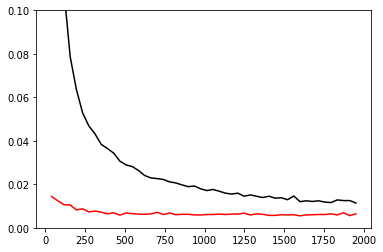

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

org = res_orig["val"]
ooc = res_ooc["val"]

assert len(org) == len(ooc)

ln = len(org)
iters = np.arange(val_iter, val_iter * ln + 1, val_iter)

plt.ylim([0.0, 0.1])
plt.plot(iters, org, "k", label="Original model")
plt.plot(iters, ooc, "r", label="Large mode with OoC training")
plt.show()


## Conclusion

As you experienced in this demo, our OoC feature enables you to train much larger model than GPU memory. It could realize the performance which cannot be done under current GPU memory limitation.
Additionally, our OoC feature would help you to train memory-intensive state-of-the-art model on affordable device.

For your information, we also implement a novel memory allocator best for OoC training. Since this allocator is based on virtual memory management feature newly supported from CUDA 10.2, you can only use this under CUDA >= 10.2. To enable this allocator, you should additionally add the code below **before setting default context**
```python
# Only available on CUDA >= 10.2
from nnabla_ext.cuda.init as cuda_init
cuda_init.prefer_cuda_virtual_array()

# Make sure to call nn.set_default_context after changing array preference
nn.set_default_context(device_ctx)
```
If your environment has CUDA >= 10.2, it is also good to try our novel memory allocator to maximize the benefit you can obtain from our OoC feature.

Try it with your own model and improve its performance more! Thanks for visiting our OoC interactive demo!